In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

### Data finding

In [2]:
DATA_DIR = "../data/welding_wave"
filenames = os.listdir(DATA_DIR)
df_list = []
type_list = []
for filename in filenames:
    hz = filename.split("_")[0]
    gap_id = filename.split("_")[1]
    gap_type = gap_id[:4]
#     welding_order = gap_id.split("mm")[-1].split(".")[0]
    
    type_list.append([hz, gap_type])
    df_list.append(
        pd.read_csv(os.path.join(DATA_DIR, filename), delimiter="\t", header=None,
                   names =["time_order", "ampere", "volt"] ))

In [3]:
modifed_df_list = []
for df, (hz, gap_type)in zip(df_list, type_list):
    df["hz"] = hz
    df["gap_type"] = gap_type
    df["gap_type"] = gap_type
    
    modifed_df_list.append(df)
all_df = pd.concat(modifed_df_list).reset_index(drop=True)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_df = all_df.copy()
X_df
X_df["hz"] = X_df.hz.replace({"2000Hz" : 0, "4000Hz" : 1})
X_df = X_df[['ampere', 'volt', 'hz']]

le = preprocessing.LabelEncoder()
le.fit(all_df.gap_type.unique())
y_df = all_df.gap_type


X = X_df.values
y = le.transform(all_df.gap_type.values) 
X_dev, X_test, y_dev, y_test = train_test_split(X, y)

In [14]:
X_df = all_df.copy()

shift_big_list = []
rolling_big_list = []
# window_size = 11
window_size = 11

for hz in ["2000Hz", "4000Hz"]:
    for gap_type in ["Gap0", "Gap2", "Gap4"]:
        target_df = X_df[(X_df["hz"] == hz) & (X_df["gap_type"] == gap_type)][['ampere', 'volt']]
        shift_small_list = []
        rolling_small_list = []
        for i in range(1, window_size):
            names = target_df.columns
            df = target_df.shift(i)
            df.columns = [name + "_shift_" + str(i) for name in names]
            shift_small_list.append(df)

            af = target_df.rolling(i).mean()
            af.columns = [name + "_rolling_" + str(i) for name in names]
            rolling_small_list.append(af)

        shift_big_list.append(pd.concat(shift_small_list, axis=1))
        rolling_big_list.append(pd.concat(rolling_small_list, axis=1))
        

X_df = pd.merge(X_df, pd.concat(shift_big_list).dropna(), how="inner" , left_index=True, right_index=True)
X_df = pd.merge(X_df, pd.concat(rolling_big_list).dropna(), how="inner" , left_index=True, right_index=True)


X_df["hz"] = X_df.hz.replace({"2000Hz" : 0, "4000Hz" : 1})
X_df["log_am"] = np.log(X_df['ampere'] + 100)
X_df["log_volt"] = np.log(X_df['volt'] + 100)



le = preprocessing.LabelEncoder()
le.fit(X_df.gap_type.unique())
y = le.transform(X_df.pop("gap_type").values) 
X = X_df.values

X_dev, X_test, y_dev, y_test = train_test_split(X, y)

In [16]:
X_dev.shape

(686618, 46)

In [6]:
def show_scatter(x, y, hue, data):
    ax = sns.scatterplot(x=x, y=y, data=data, hue=hue)
    plt.legend()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [ ]:
from sklearn.manifold import TSNE

data = X_dev
data_embedded = TSNE(n_components=2).fit_transform(data)
embed_df = pd.DataFrame(data_embedded, columns=["X" , "Y"])
embed_df["target_names"] = y_dev
show_scatter(x="X", y="Y", data=embed_df, hue="target_names")

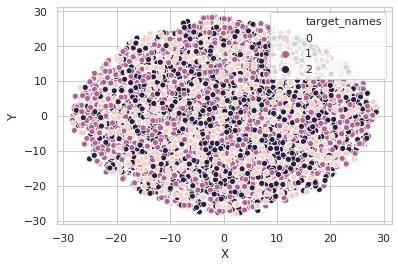

/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


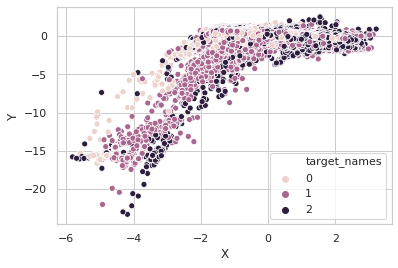

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


data = X_dev
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(data, y_dev)
data_embedded = lda.transform(data)

embed_df = pd.DataFrame(data_embedded, columns=["X" , "Y"])
embed_df["target_names"] = y_dev
show_scatter(x="X", y="Y", data=embed_df, hue="target_names")

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

def get_welding_wave_classification_result(clf,  X_dev, y_dev, n_polynomial=1, kfold_split=3):
    kf = KFold(n_splits=kfold_split, shuffle=True)
    result_val = []
    result_train = []

    for train_idx, val_idx in kf.split(X_dev):
        X_train = X_dev[train_idx, :]
        X_val = X_dev[val_idx, :]
        y_train = y_dev[train_idx]
        y_val = y_dev[val_idx]

        poly = PolynomialFeatures(n_polynomial)

        X_train = poly.fit_transform(X_train)
        clf.fit(X_train, y_train) 

        X_val = poly.fit_transform(X_val)
        y_pred = clf.predict(X_val)
        y_true =  y_val
        result_val.append(accuracy_score(y_pred, y_true))

        y_pred = clf.predict(X_train)
        y_true = y_train
        result_train.append(accuracy_score(y_pred, y_true))
    return np.mean(result_train), np.mean(result_val)

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


data = X_dev
tsvd = TruncatedSVD(n_components=10)
tsvd.fit(data)
data_embedded = tsvd.transform(data)

get_welding_wave_classification_result(
    LogisticRegression(), data_embedded, y_dev
)

KeyboardInterrupt: 

In [ ]:
get_welding_wave_classification_result(
    LogisticRegression(), X_dev, y_dev, n_polynomial=1
)

### Add time-series analysis

In [8]:
X_df = all_df.copy()

shift_big_list = []
rolling_big_list = []
# window_size = 11
window_size = 11

for hz in ["2000Hz", "4000Hz"]:
    for gap_type in ["Gap0", "Gap2", "Gap4"]:
        target_df = X_df[(X_df["hz"] == hz) & (X_df["gap_type"] == gap_type)][['ampere', 'volt']]
        shift_small_list = []
        rolling_small_list = []
        for i in range(1, window_size):
            names = target_df.columns
            df = target_df.shift(i)
            df.columns = [name + "_shift_" + str(i) for name in names]
            shift_small_list.append(df)

            af = target_df.rolling(i).mean()
            af.columns = [name + "_rolling_" + str(i) for name in names]
            rolling_small_list.append(af)

        shift_big_list.append(pd.concat(shift_small_list, axis=1))
        rolling_big_list.append(pd.concat(rolling_small_list, axis=1))
        

X_df = pd.merge(X_df, pd.concat(shift_big_list).dropna(), how="inner" , left_index=True, right_index=True)
X_df = pd.merge(X_df, pd.concat(rolling_big_list).dropna(), how="inner" , left_index=True, right_index=True)


X_df["hz"] = X_df.hz.replace({"2000Hz" : 0, "4000Hz" : 1})
X_df["log_am"] = np.log(X_df['ampere'] + 100)
X_df["log_volt"] = np.log(X_df['volt'] + 100)



le = preprocessing.LabelEncoder()
le.fit(X_df.gap_type.unique())
y = le.transform(X_df.pop("gap_type").values) 
X = X_df.values

X_dev, X_test, y_dev, y_test = train_test_split(X, y)

In [12]:
from sklearn.decomposition import TruncatedSVD 
from sklearn.linear_model import LogisticRegression

data = X_dev
tsvd = TruncatedSVD(n_components=10)
tsvd.fit(data)
data_embedded = tsvd.transform(data)

get_welding_wave_classification_result(
    LogisticRegression(), data_embedded, y_dev
)

(0.4089639368256062, 0.4087673213925072)

In [ ]:
get_welding_wave_classification_result(
    LogisticRegression(), X_dev, y_dev
)

In [20]:
X_dev.shape

(686618, 46)

In [21]:
data_embedded.shape

(686618, 10)

In [22]:
X_full = np.concatenate((X_dev, data_embedded), axis=1)
X_full.shape

(686618, 56)

In [33]:
get_welding_wave_classification_result(
    LogisticRegression(), X_full, y_dev
)

(0.4314225661913836, 0.43141018901845946)

In [26]:
from sklearn.ensemble import RandomForestClassifier 

get_welding_wave_classification_result(
    RandomForestClassifier(n_jobs = 6), 
    X_full, y_dev, n_polynomial=1
)

(0.9907160896335871, 0.640581809420044)

In [27]:
from hpsklearn import HyperoptEstimator, decision_tree
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_full, y_dev)

estim = HyperoptEstimator(classifier=decision_tree('myDT'))
estim.fit(X_train, y_train)

print(estim.score(X_val, y_val))

100%|██████████| 1/1 [00:05<00:00,  5.57s/it, best loss: 0.0007184954317284165]
0.5359878826716379


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_full, y_dev)

import autosklearn.classification
automl = autosklearn.classification.AutoSklearnClassifier( include_estimators=["random_forest", "xgradient_boosting", ], 
    include_preprocessors=["no_preprocessing", ], 
    seed = 42,ml_memory_limit = 30720,
    resampling_strategy = 'holdout',
    n_jobs=8)
                                                          
automl.fit(X_train.copy(), y_train.copy())
y_hat = automl.predict(X_val)
print("Accuracy score", sklearn.metrics.accuracy_score(y_val, y_hat))

/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full

[WARNING] [2019-11-04 15:20:22,136:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:20:22,172:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!


/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-11-04 15:20:24,196:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:20:26,204:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:20:28,228:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:20:30,256:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:20:32,288:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:20:34,316:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:20:36,344:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than

[WARNING] [2019-11-04 15:22:17,700:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:22:19,718:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:22:21,744:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:22:23,772:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:22:25,800:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:22:27,828:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:22:29,852:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than

[WARNING] [2019-11-04 15:24:11,144:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:24:13,164:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:24:15,192:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:24:17,220:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:24:19,248:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:24:21,276:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than random - using Dummy Score!
[WARNING] [2019-11-04 15:24:23,304:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] No models better than

/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full

[WARNING] [2019-11-04 15:38:42,316:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-11-04 15:38:42,316:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full

[WARNING] [2019-11-04 15:51:14,773:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-11-04 15:51:14,773:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full

[WARNING] [2019-11-04 15:56:32,841:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] Memory Exception -- restart with less ensemle_nbest: 25
[WARNING] [2019-11-04 15:56:33,780:EnsembleBuilder(1608637542):bd0b82f050700033205967dad11c9814] Memory Exception -- restart with less ensemle_nbest: 12


/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full

[WARNING] [2019-11-04 16:19:59,535:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-11-04 16:19:59,535:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-11-04 16:20:02,378:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-11-04 16:20:02,378:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-11-04 16:20:03,028:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-11-04 16:20:03,028:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-11-04 16:20:05,375:smac.intensification.intensificatio

In [36]:
print("Accuracy score", accuracy_score(y_val, y_hat))

Accuracy score 0.6355596982319187


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev)

import autosklearn.classification
automl = autosklearn.classification.AutoSklearnClassifier( ml_memory_limit=30720,)
automl.fit(X_train.copy(), y_train.copy())
y_hat = automl.predict(X_val)

/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-11-05 06:21:02,000:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:21:02,023:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:21:04,028:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:21:06,033:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:21:08,039:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:21:10,044:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:21:12,048:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:21:14,052

[WARNING] [2019-11-05 06:23:00,302:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:23:02,307:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:23:04,312:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:23:06,316:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:23:08,320:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:23:10,324:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:23:12,328:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:23:14,332

[WARNING] [2019-11-05 06:25:00,571:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:25:02,576:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:25:04,580:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:25:06,584:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:25:08,588:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:25:10,593:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:25:12,598:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!
[WARNING] [2019-11-05 06:25:14,603

/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-11-05 06:25:28,635:EnsembleBuilder(1):72cc99164a3589918b510aaad18cef02] No models better than random - using Dummy Score!


/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


In [40]:
print("Accuracy score", accuracy_score(y_val, y_hat))

Accuracy score 0.6626780460808016


In [44]:
print(automl.show_models())

[(0.580000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'categorical_encoding:__choice__': 'one_hot_encoding', 'classifier:__choice__': 'random_forest', 'imputation:strategy': 'most_frequent', 'preprocessor:__choice__': 'no_preprocessing', 'rescaling:__choice__': 'standardize', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5686453602598863, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'classifier:random_forest:n_estimators': 100, 'categorical_encoding:one_hot_encoding:minimum_fraction': 0.41094614430753584},
dataset_properties={
  'task': 2,
  'sparse'